In [3]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now you can import directly
from examples.libero.schemas import ActionChunk, Timestamp

In [41]:
# data_dir = "/nethome/dhe83/flash/openpi/data/libero/multi_robot_videos"
# data_dir = "/nethome/dhe83/flash/openpi/data/libero/sync"
# data_dir = "/nethome/dhe83/flash/openpi/data/libero/benchmark_end_to_end/batch_size_4_num_robots_1_broker_type_SYNC"
data_dir = "/nethome/dhe83/flash/openpi/data/libero/debug_sync_4"
action_chunk_files = glob.glob(os.path.join(data_dir, "*/*"))
print(action_chunk_files)

latencies = []
arrival_times = []
simulation_step_times = []
for f in tqdm(action_chunk_files):
    action_chunk_filepath = os.path.join(f, "action_chunks.csv")
    timestamp_filepath = os.path.join(f, "timestamps.csv")
    chunks = ActionChunk.from_csv(action_chunk_filepath)
    timestamps = Timestamp.from_csv(timestamp_filepath)

    latencies.extend([chunk.latency for chunk in chunks])
    arrival_times.extend([chunk.request_timestamp for chunk in chunks])
    simulation_step_times.extend([curr.timestamp - prev.timestamp for curr, prev in zip(timestamps[1:], timestamps)])

['/nethome/dhe83/flash/openpi/data/libero/debug_sync_4/0/0_libero_spatial_0_success']


100%|██████████| 1/1 [00:00<00:00, 325.17it/s]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0., 15., 73., 14.]),
 array([0.01785898, 0.02161574, 0.02537251, 0.02912927, 0.03288603,
        0.03664279, 0.04039955, 0.04415631, 0.04791307, 0.05166984,
        0.0554266 ]),
 <BarContainer object of 10 artists>)

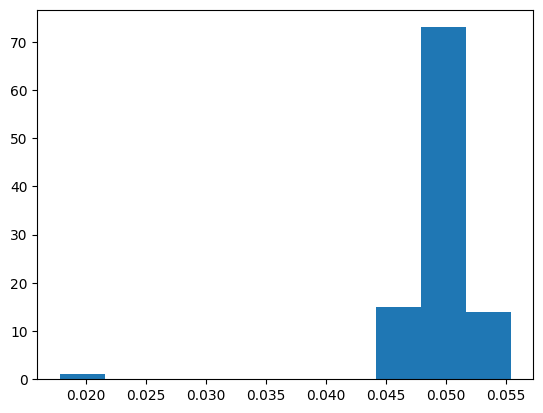

In [42]:
plt.hist(simulation_step_times)

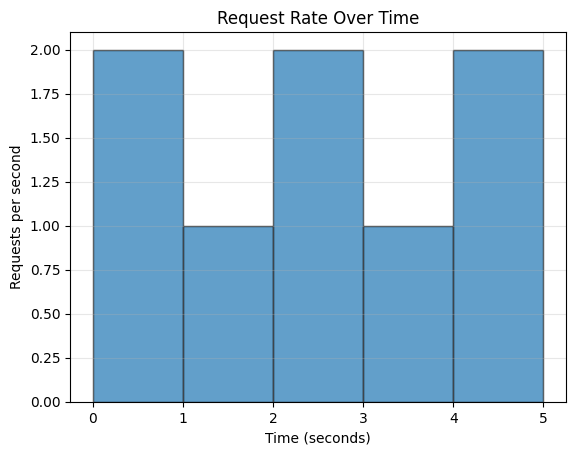

In [43]:
arrival_times = np.array(arrival_times)
arrival_times = arrival_times - min(arrival_times)

# Create bins of exactly size 1
max_time = int(np.ceil(arrival_times.max()))
bins = np.arange(0, max_time + 1, 1)  # [0, 1, 2, 3, ..., max_time]

plt.hist(arrival_times, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Requests per second')
plt.title('Request Rate Over Time')
plt.grid(True, alpha=0.3)
plt.show()

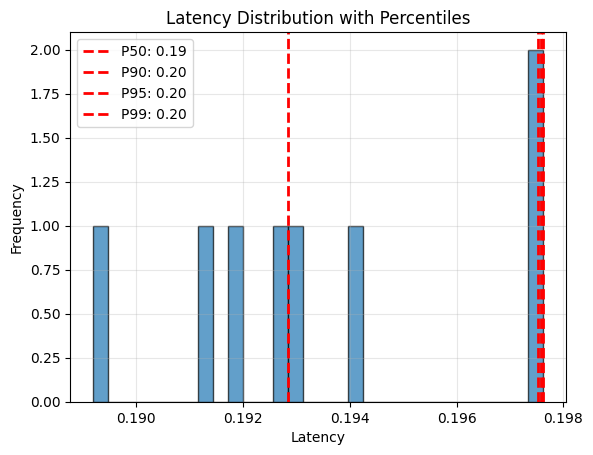

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(latencies, bins=30, alpha=0.7, edgecolor='black')

# Calculate and plot percentiles
percentiles = [50, 90, 95, 99]
for p in percentiles:
    value = np.percentile(latencies, p)
    plt.axvline(value, color='red', linestyle='--', linewidth=2, 
                label=f'P{p}: {value:.2f}')

plt.xlabel('Latency')
plt.ylabel('Frequency')
plt.title('Latency Distribution with Percentiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()